# Chapter 4

## Set Up

### Packages

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats

### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [94]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## 4.3 Gaussian model of height

In [5]:
# load data
howell = load_data(HOWELL_FILE, delimiter=";")

# get adult heights
height = howell.loc[howell["age"] >= 18, "height"].values

Plot the distribution

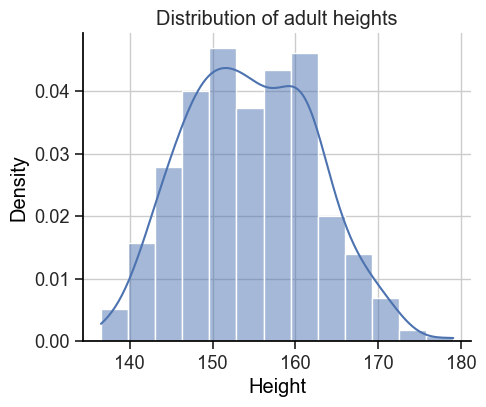

In [6]:
fig, ax = plt.subplots(figsize=(5, 4))

sns.histplot(height, kde=True, stat="density")

ax.set(
    xlabel="Height",
    title="Distribution of adult heights",
);

Set and plot priors

In [7]:
def plot_priors(priors):  
    n_priors = len(priors)

    ax_width = 6
    width = ax_width * n_priors

    fig, axs = plt.subplots(ncols=n_priors, figsize=(width, 4))

    for ax, (name, prior) in zip(axs, priors.items()):
        x_min, x_max = prior.ppf([0.001, 0.999])
        x_plot = np.linspace(x_min, x_max, 1000)
        y_plot = prior.pdf(x_plot)

        ax.plot(x_plot, y_plot)

        ax.set(
            ylabel="Density",
            title=name
        )

    fig.suptitle("Prior Density Functions")
    
    return fig, axs

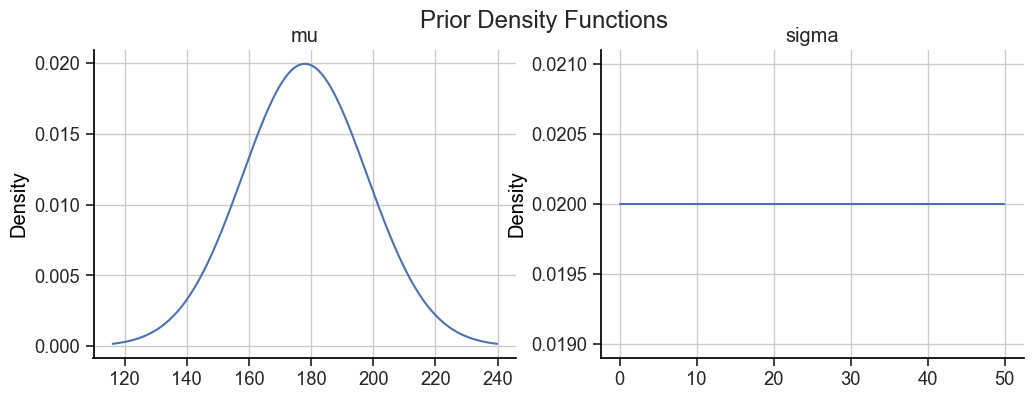

In [8]:
# priors
mu_prior = stats.norm(loc=178, scale=20)
sigma_prior = stats.uniform(0, 50)

priors = {
    "mu": mu_prior,
    "sigma": sigma_prior,
}
plot_priors(priors);

Plot the prior predictive

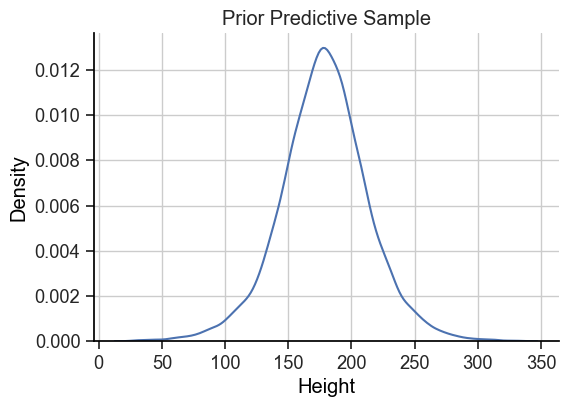

In [9]:
n_sample = 10000
mu_sample = mu_prior.rvs(n_sample)
sigma_sample = sigma_prior.rvs(n_sample)

prior_pred_sample = stats.norm.rvs(loc=mu_sample, scale=sigma_sample, size=n_sample)

# plot distribution
fig, ax = plt.subplots(figsize=(6, 4))

sns.kdeplot(prior_pred_sample, ax=ax)

ax.set(
    xlabel="Height",
    title="Prior Predictive Sample"
);

Grid approximation of the posterior

In [10]:
def calculate_height_posterior_with_grid_approximation(height, mu_range, mu_prior, sigma_range, sigma_prior):
    # take cross-product to get grids of pairs
    mu_grid, sigma_grid = np.meshgrid(mu_range, sigma_range)

    # get total log likelihood by taking sum of log likelihoods for each observation
    log_likelihood = np.array([
        stats.norm.logpdf(height[i], loc=mu_grid, scale=sigma_grid) for i in range(len(height))
    ]).sum(axis=0)

    # get log prior values at grid points
    mu_prior_log_val = mu_prior.logpdf(mu_grid)
    sigma_prior_log_val = sigma_prior.logpdf(sigma_grid)

    # update prior in log world
    log_posterior = log_likelihood + mu_prior_log_val + sigma_prior_log_val

    # get posterior
    posterior = np.exp(log_posterior - np.max(log_posterior))
    posterior /= posterior.sum()
    
    return posterior, mu_grid, sigma_grid

In [11]:
mu_range = np.linspace(150, 169, 100)
sigma_range = np.linspace(7, 9, 100)

posterior, mu_grid, sigma_grid = calculate_height_posterior_with_grid_approximation(
    height,
    mu_range,
    mu_prior,
    sigma_range,
    sigma_prior
)

Plot joint distribution of posterior

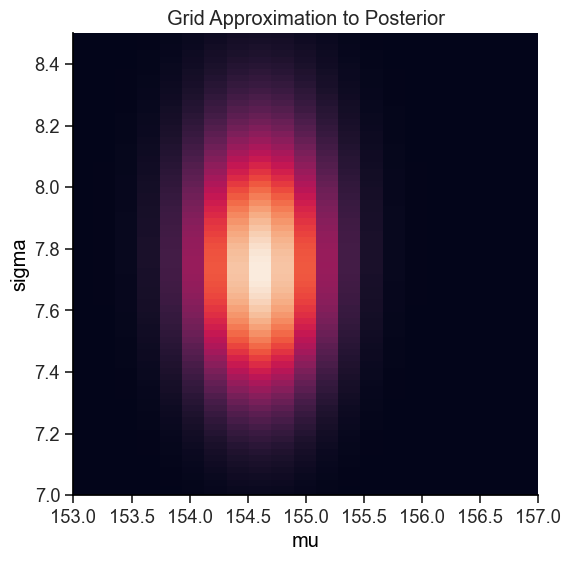

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.pcolormesh(mu_grid, sigma_grid, posterior);

ax.set(
    xlim=[153, 157],
    ylim=[7, 8.5],
    xlabel="mu",
    ylabel="sigma",
    title="Grid Approximation to Posterior",
);

Sample the posterior. We sample the index of the ravelled grid and use this to sample mu and sigma.

In [13]:
def sample_height_posterior(posterior):
    n_sample = np.prod(posterior.shape)
    grid_ravel_idx = np.arange(n_sample)

    samples_idx = np.random.choice(grid_ravel_idx, size=n_sample, p=posterior.ravel(), replace=True)

    mu_samples = mu_grid.ravel()[samples_idx]
    sigma_samples = sigma_grid.ravel()[samples_idx]
    
    return mu_samples, sigma_samples

In [14]:
mu_samples, sigma_samples = sample_height_posterior(posterior)

Plot the posterior sample

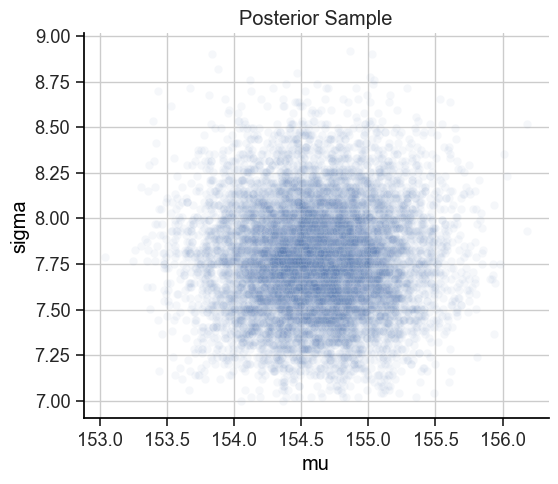

In [15]:
fig, ax = plt.subplots(figsize=(6, 5))

# add some jitter or the points are all on top of each other
mu_jitter_std = 0.1
mu_jitter = stats.norm.rvs(loc=0, scale=mu_jitter_std, size=len(mu_samples))

sns.scatterplot(
    x=mu_samples+mu_jitter,
    y=sigma_samples,
    alpha=0.05,
    ax=ax,
)

ax.set(
    xlabel="mu",
    ylabel="sigma",
    title="Posterior Sample",
);

We can also plot a joint density plot

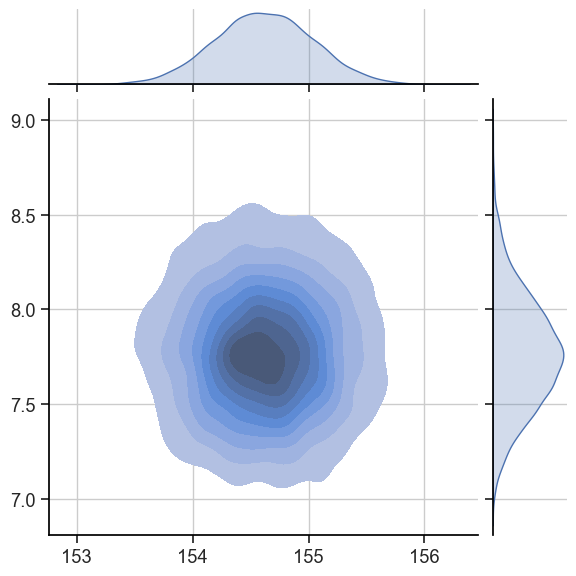

In [16]:
sns.jointplot(
    x=mu_samples+mu_jitter,
    y=sigma_samples,
    kind="kde",
    fill=True,
);

Try repeating the above with less data

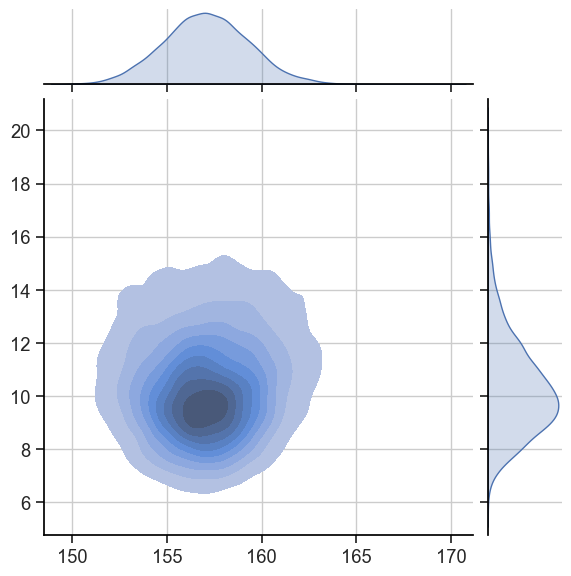

In [17]:
mu_range = np.linspace(150, 170, 100)
sigma_range = np.linspace(4, 20, 100)

height_sample = np.random.choice(height, size=20, replace=False)
posterior, mu_grid, sigma_grid = calculate_height_posterior_with_grid_approximation(
    height_sample,
    mu_range,
    mu_prior,
    sigma_range,
    sigma_prior
)

mu_samples, sigma_samples = sample_height_posterior(posterior)

sns.jointplot(
    x=mu_samples+mu_jitter,
    y=sigma_samples,
    kind="kde",
    fill=True,
);

The posterior is a lot wider and the parameter $\sigma$ is a lot less normal - it has a long tail.

### 4.3.5 Finding the posterior distribution with `quap`

Now let's try generating the posterior using PyMC, since we don't have a package to do quadratic approximation

In [23]:
# load data
howell = load_data(HOWELL_FILE, delimiter=";")

# get adult heights
data = howell.loc[howell["age"] >= 18, "height"]

In [47]:
with pm.Model() as m4_1:
    # stochastic random variables (priors)
    mu = pm.Normal("mu", mu=178, sigma=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    
    # observed stochastic (likelihood)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data)
    
    # draw 1000 posterior samples
    # returns InferenceData object
    trace_4_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Get summary stats for the posterior distributions

In [48]:
az.summary(trace_4_1, kind="stats", hdi_prob=0.89, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.60,0.42,153.94,155.29
sigma,7.77,0.29,7.32,8.24


Try more informative priors:

In [49]:
with pm.Model() as m4_2:
    # stochastic random variables (priors)
    mu = pm.Normal("mu", mu=178, sigma=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    
    # observed stochastic (likelihood)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=data)
    
    # draw 1000 posterior samples
    trace_4_2 = pm.sample()

az.summary(trace_4_2, kind="stats", hdi_prob=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%
mu,177.87,0.10,177.71,178.03
sigma,24.60,0.95,23.04,26.01


## 4.4 Linear prediction

Plot height against weight.

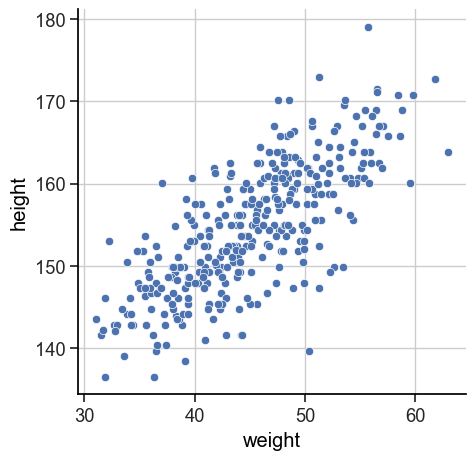

In [201]:
# load data
howell = load_data(HOWELL_FILE, delimiter=";")
adult = howell.loc[howell["age"] >= 18, :]

# plot height against weight
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(adult, x="weight", y="height", ax=ax);

### 4.4.1 The linear model strategy

Simulate linear relationships by sampling priors

In [134]:
def plot_linear_weight_model_prior_predictive_manual(adult, alpha_prior, beta_prior, n_draw=100, ax=None): 
    # sample the priors
    alpha_sample = alpha_prior.rvs(size=n_draw)
    beta_sample = beta_prior.rvs(size=n_draw)
    
    weights = adult.weight.values
    
    # coerce into shapes (n_weight, n_draw)
    alpha_grid, weights_grid = np.meshgrid(alpha_sample, weights)
    beta_grid, _ = np.meshgrid(beta_sample, weights)

    heights_grid = alpha_grid + beta_grid * (weights_grid - weights_grid.mean(axis=0))
    
    # plot the data
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 4))

    for draw in range(n_draw):
        ax.plot(weights_grid[:, draw], heights_grid[:, draw], color="k", lw=0.2, alpha=0.5)

    ax.axhline(0, ls="--", lw=0.8, color="k")
    ax.axhline(272, lw=0.8, color="k")

    ax.set(
        ylim=[-100, 400],
        xlabel="weight",
        ylabel="height",
    )

Try it out with two different priors for the slope beta.

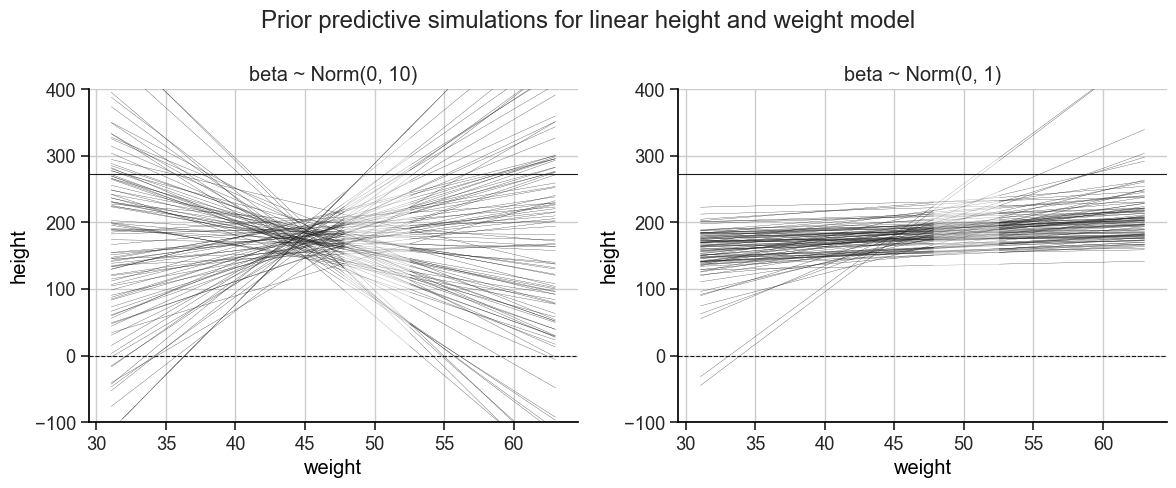

In [154]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

alpha_prior = stats.norm(loc=178, scale=20)
beta_prior_0 = stats.norm(loc=0, scale=10)
beta_prior_1 = stats.lognorm(s=1)

plot_linear_weight_model_prior_predictive_manual(adult, alpha_prior, beta_prior_0, ax=ax0)
plot_linear_weight_model_prior_predictive_manual(adult, alpha_prior, beta_prior_1, ax=ax1)

ax0.set(title="beta ~ Norm(0, 10)")
ax1.set(title="beta ~ Norm(0, 1)")

fig.suptitle("Prior predictive simulations for linear height and weight model")
plt.tight_layout();

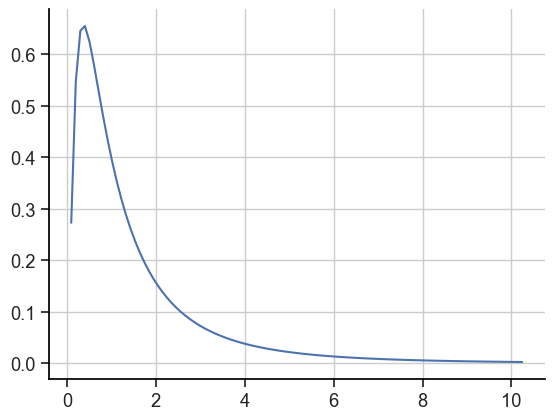

In [156]:
x_plot = np.linspace(
    beta_prior_1.ppf(0.001),
    beta_prior_1.ppf(0.99),
    100
)
y_plot = beta_prior_1.pdf(x_plot)
plt.plot(x_plot, y_plot)

We can do this in PyMC instead.

In [165]:
def plot_linear_weight_model_prior_predictive_pymc(adult, alpha_prior_kwargs, beta_prior_kwargs, beta_prior_dist="norm", n_draw=100, ax=None): 
    
    weight = adult.weight
    weight_scaled = weight - weight.mean()

    with pm.Model():
        # priors
        alpha = pm.Normal("alpha", **alpha_prior_kwargs)
        if beta_prior_dist == "norm":
            beta = pm.Normal("beta", **beta_prior_kwargs)
        elif beta_prior_dist == "log_norm":
            beta = pm.LogNormal("beta", **beta_prior_kwargs)
        else:
            raise ValueError("Beta must have either 'norm' or 'log_norm' distribution")
        
        # in the example sigma is 0 - we approximate this with a very tight prior
        sigma = pm.Uniform("sigma", lower=0, upper=0.1)

        # deterministic
        mu = alpha + beta * weight_scaled

        # observed
        height = pm.Normal("height", mu=mu, sigma=sigma, observed=adult.height)

        trace = pm.sample_prior_predictive(samples=n_draw, random_seed=RANDOM_SEED)

    # get the prior predictive
    prior_pred = trace.prior_predictive
    
    # plot the data
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 4))

    for draw in range(n_draws):
        ax.plot(weight, prior_pred.height.sel(chain=0, draw=draw), color="k", lw=0.2, alpha=0.5)

    ax.axhline(0, ls="--", lw=0.8, color="k")
    ax.axhline(272, lw=0.8, color="k")

    ax.set(
        ylim=[-100, 400],
        xlabel="weight",
        ylabel="height",
    )

Sampling: [alpha, beta, height, sigma]
Sampling: [alpha, beta, height, sigma]


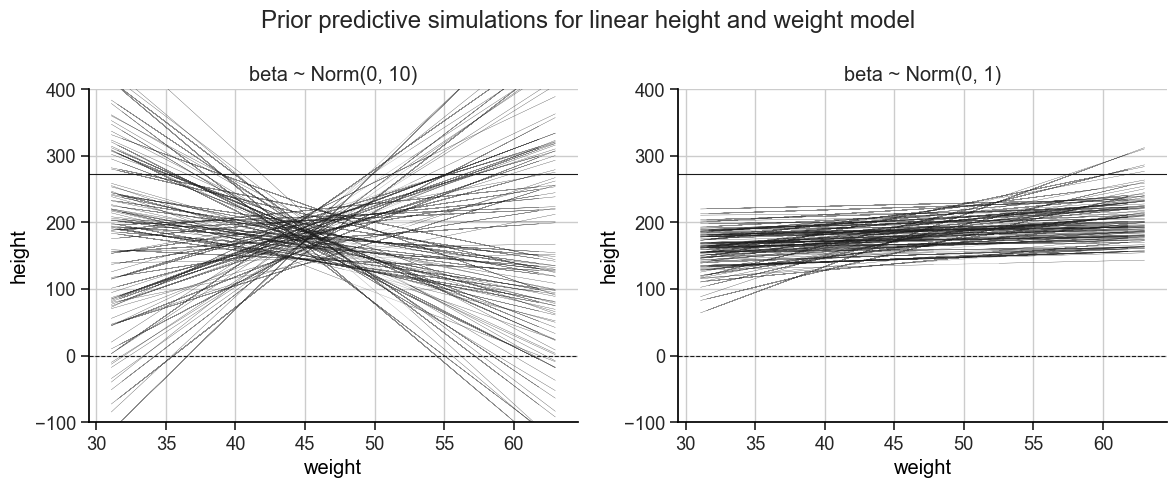

In [166]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

alpha_prior_kwargs = {"mu": 178, "sigma": 20}
beta_prior_kwargs_0 = {"mu": 0, "sigma": 10}
beta_prior_kwargs_1 = {"mu": 0, "sigma": 1}

plot_linear_weight_model_prior_predictive_pymc(adult, alpha_prior_kwargs, beta_prior_kwargs_0, ax=ax0)
plot_linear_weight_model_prior_predictive_pymc(adult, alpha_prior_kwargs, beta_prior_kwargs_1, beta_prior_dist="log_norm", ax=ax1)

ax0.set(title="beta ~ Norm(0, 10)")
ax1.set(title="beta ~ Norm(0, 1)")

fig.suptitle("Prior predictive simulations for linear height and weight model")
plt.tight_layout();

### 4.4.2 Interpreting the posterior distribution

In [507]:
# reload the data
howell = load_data(HOWELL_FILE, delimiter=";")
adult = howell.loc[howell["age"] >= 18, :]

Specify the model and sample the posterior

In [527]:
with pm.Model() as m4_3:
    # priors
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.LogNormal("beta", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)

    # data
    weight = pm.MutableData("weight", adult.weight)

    # deterministic
    mu = pm.Deterministic("mu", alpha + beta * (weight - weight.mean()))

    # observed
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=adult.height)

    # sample posterior
    trace_4_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Summarise the posterior distributions

In [536]:
az.summary(trace_4_3, var_names=["alpha", "beta", "sigma"], kind="stats", hdi_prob=0.89, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,154.6,0.28,154.16,155.04
beta,0.9,0.04,0.83,0.96
sigma,5.1,0.20,4.78,5.41


Get covariance. Annoying we have to remove the extra dimensions coming from weight and mu.

In [560]:
trace_df = trace_4_3.posterior.drop("mu").mean(dim=["mu_dim_0"]).to_dataframe()
trace_df

alpha      beta     sigma
chain draw                                
0     0     154.785874  0.903133  5.332012
      1     154.221904  0.819530  5.271976
      2     154.377900  0.892642  4.978338
      3     154.832890  0.876428  4.732584
      4     154.545414  0.962385  5.183643
...                ...       ...       ...
3     995   154.495977  0.901970  5.177437
      996   154.447168  0.918192  4.926764
      997   154.318428  0.896972  5.375060
      998   154.958282  0.919432  4.830615
      999   154.380929  0.897821  5.354215

[4000 rows x 3 columns]

Note that this is actually 1000 draws from 4 different chains. We could restrict to a single chain, but it doesn't really matter.

In [561]:
trace_df.cov().round(3)

,alpha,beta,sigma
alpha,0.077,0.000,0.001
beta,0.000,0.002,0.000
sigma,0.001,0.000,0.039


Now plot the regression line arising from the posterior means

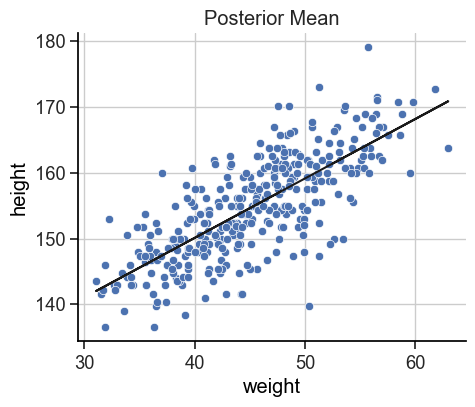

In [562]:
fig, ax = plt.subplots(figsize=(5, 4))

# plot data
sns.scatterplot(adult, x="weight", y="height", ax=ax);

alpha_mean = trace_4_3.posterior.alpha.mean().item(0)
beta_mean = trace_4_3.posterior.beta.mean().item(0)

weight = trace_4_3.constant_data.weight
height_est = alpha_mean + beta_mean * (weight - weight.mean())

ax.plot(weight, height_est, color="k")

ax.set(title="Posterior Mean");

Now sample the posterior and plot the resulting lines against the actual data.

In [563]:
def plot_posterior_lines(adult, n_samples=None, n_lines=20, ax=None):
    if not n_samples:
        n_samples = adult.shape[0]
    
    with pm.Model():
        # priors
        alpha = pm.Normal("alpha", **alpha_prior_kwargs)
        beta = pm.LogNormal("beta", mu=0, sigma=1)
        sigma = pm.Uniform("sigma", lower=0, upper=50)

        # data
        weight = pm.MutableData("weight", adult.weight.iloc[:n_samples])
        weight_scaled = pm.Deterministic("weight_scaled", weight - weight.mean()) 

        # deterministic
        mu = pm.Deterministic("mu", alpha + beta * weight_scaled)

        # observed
        height = pm.Normal("height", mu=mu, sigma=sigma, observed=adult.height.iloc[:n_samples])

        # sample posterior
        trace = pm.sample(1000)

    
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 4))

    # plot data
    sns.scatterplot(adult.iloc[:n_samples], x="weight", y="height", ax=ax);

    for draw in range(n_lines):
        ax.plot(
            trace.constant_data.weight,
            trace.posterior.mu.sel(chain=0, draw=draw),
            color="k", lw=0.2, alpha=0.5
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


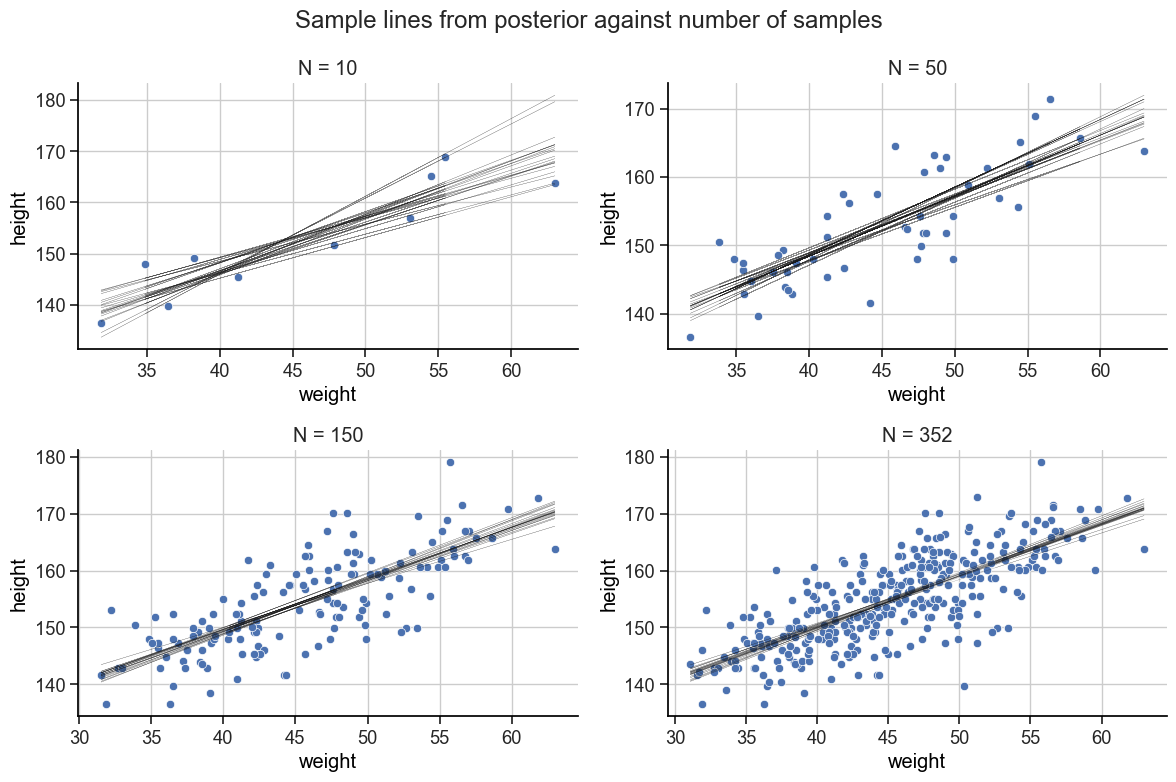

In [564]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

n_samples_list = [10, 50, 150, 352]

axs_ravel = axs.ravel()
for n_samples, ax in zip(n_samples_list, axs_ravel):
    plot_posterior_lines(adult, n_samples=n_samples, ax=ax)
    ax.set(title=f"N = {n_samples}")

fig.suptitle("Sample lines from posterior against number of samples")
fig.tight_layout();

Let's plot the distribution of $\mu$ for fixed weight=50

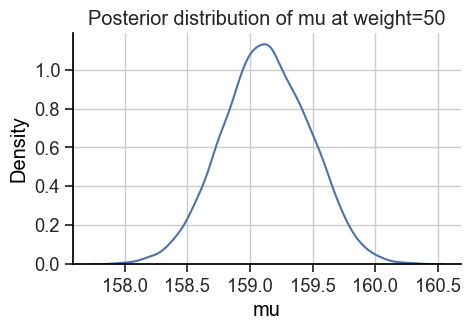

In [565]:
# combine everything into a single sample for each param
data_4_3 = az.extract(trace_4_3)

# calculate mu
weight = trace_4_3.constant_data.weight
mu_at_50 = data_4_3.alpha + data_4_3.beta * (50 - weight.mean())

# plot
fig, ax = plt.subplots(figsize=(5, 3))

sns.kdeplot(mu_at_50, ax=ax)

ax.set(
    xlabel="mu",
    title="Posterior distribution of mu at weight=50"
);

In [566]:
# percentile interval
print(az.hdi(mu_at_50.values, hdi_prob=0.89).round(2))

[158.55 159.66]


We can also plot a HDI around the regression line

In [568]:
mu_hdi = az.hdi(trace_4_3a.posterior.mu, hdi_prob=0.89)
mu_hdi

<xarray.Dataset>
Dimensions:   (mu_dim_0: 352, hdi: 2)
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 7 ... 345 346 347 348 349 350 351
  * hdi       (hdi) <U6 'lower' 'higher'
Data variables:
    mu        (mu_dim_0, hdi) float64 156.7 157.6 146.2 ... 163.5 160.7 162.1

To get the mean values we can just average over all chains and draws

In [573]:
mu_mean = trace_4_3.posterior.mu.mean(dim=["chain", "draw"])
mu_mean

<xarray.DataArray 'mu' (mu_dim_0: 352)>
array([157.16279813, 146.91603318, 142.74047646, 161.87631   ,
       151.24529137, 170.86784625, 148.50428175, 164.07936447,
       145.45586918, 163.18277254, 159.03283273, 151.19405755,
       146.50616258, 157.04929875, 144.53366033, 157.82883785,
       152.19311713, 148.6067494 , 158.21309154, 152.5517539 ,
       146.01944125, 148.1968788 , 145.99382433, 150.37431635,
       163.74634461, 147.83824203, 148.73483396, 156.0612709 ,
       149.04223691, 146.09629198, 156.77854444, 157.21403195,
       158.59734522, 158.57172831, 165.05280714, 149.29840603,
       159.03283273, 151.21967446, 148.78606778, 152.26016188,
       154.29370394, 166.89722483, 156.16373855, 153.90945026,
       159.94085308, 163.02907106, 155.42084809, 157.34211651,
       161.13341955, 156.98347974, 155.19029588, 152.26996787,
       146.91603318, 164.48923507, 147.55645599, 157.59828564,
       147.68454055, 156.57360914, 156.67607679, 165.94939907,
       148.22249571, 156.59922606, 152.98724141, 159.36585259,
       149.52895824, 159.75019122, 149.58019207, 146.73671479,
       155.75386795, 152.1418833 , 156.98347974, 164.28429977,
       157.82883785, 152.62860464, 145.63518756, 165.23212552,
       160.26244453, 156.62484297, 150.93788842, 143.50898383,
...
       160.05750923, 150.78418695, 147.88947585, 160.56984747,
       154.44740542, 153.1665598 , 156.16373855, 149.68265972,
       145.37901844, 149.4521075 , 147.7870082 , 157.9313055 ,
       146.1219089 , 153.44834583, 157.49581799, 160.0062754 ,
       153.70451496, 157.49581799, 156.13812163, 164.92472258,
       157.85445476, 157.5214349 , 156.85539518, 146.07067507,
       147.01921965, 158.18747462, 160.26244453, 155.98442016,
       147.35152069, 157.90568859, 148.32496336, 156.67607679,
       164.00251373, 162.92660341, 157.75198711, 152.85915685,
       144.84106328, 159.08406656, 154.01191791, 144.17502356,
       156.67607679, 155.62578339, 156.77854444, 150.86103769,
       159.44270333, 154.72919145, 152.11626639, 151.57831123,
       154.80604219, 160.26244453, 158.46926066, 160.2112107 ,
       153.5764304 , 146.04505816, 152.6987926 , 156.21497237,
       151.78324653, 148.46499682, 153.07341154, 162.41426516,
       152.78230611, 149.88759502, 153.11532597, 161.54329014,
       148.68360013, 152.62860464, 146.37807802, 153.90945026,
       148.35058027, 153.80698261, 153.73013187, 157.21403195,
       149.55457515, 151.04035607, 150.83542077, 156.44552458,
       144.8922971 , 161.08218572, 162.79851885, 161.41520558])
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 7 ... 345 346 347 348 349 350 351

We need to order by weight in the plot so it's convenient to collect all the data into a dataframe.

In [574]:
mu_plot_data = pd.DataFrame(
    {
        "weight": trace_4_3.constant_data.weight,
        "mean": mu_mean,
        "hdi_lower": mu_hdi.mu.sel(hdi="lower"),
        "hdi_higher": mu_hdi.mu.sel(hdi="higher"),
    }
).sort_values("weight")

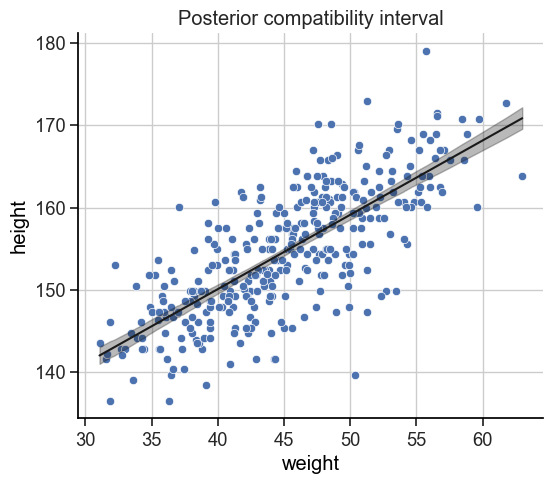

In [576]:
fig, ax = plt.subplots(figsize=(6, 5))

# plot true data
sns.scatterplot(adult.iloc[:n_samples], x="weight", y="height", ax=ax);

# plot the mean at each weight
ax.plot(mu_plot_data["weight"], mu_plot_data["mean"], color="k")

ax.fill_between(
    mu_plot_data["weight"],
    mu_plot_data["hdi_lower"],
    mu_plot_data["hdi_higher"],
    color="k",
    alpha=0.3
)

ax.set(title="Posterior compatibility interval");

We add in the uncertainty coming from $\mu$ by taking a posterior predictive sample and constructing an HDI at each weight value

In [578]:
with m4_3:
    post_pred_sample = pm.sample_posterior_predictive(trace_4_3)

Sampling: [height]


In [587]:
height_hdi = az.hdi(post_pred_sample.posterior_predictive.height, hdi_prob=0.89)
post_pred_plot_data = pd.DataFrame(
    {
        "weight": trace_4_3.constant_data.weight,
        "hdi_lower": height_hdi.height.sel(hdi="lower"),
        "hdi_higher": height_hdi.height.sel(hdi="higher"),
    }
).sort_values("weight")

Now add this to the plot above

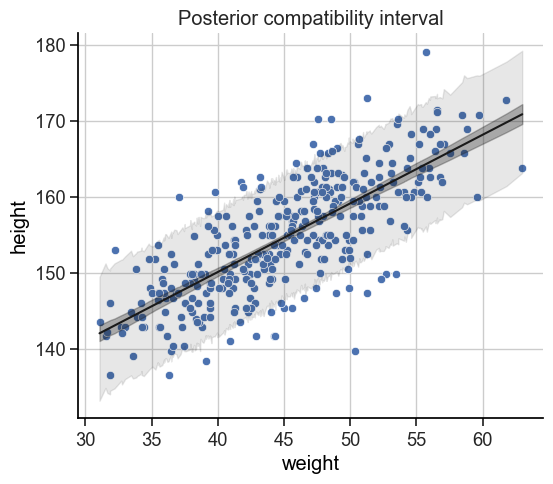

In [588]:
fig, ax = plt.subplots(figsize=(6, 5))

# plot true data
sns.scatterplot(adult.iloc[:n_samples], x="weight", y="height", ax=ax);

# plot the mean at each weight
ax.plot(mu_plot_data["weight"], mu_plot_data["mean"], color="k")

# mu HDI
ax.fill_between(
    mu_plot_data["weight"],
    mu_plot_data["hdi_lower"],
    mu_plot_data["hdi_higher"],
    color="k",
    alpha=0.3
)

# posterior predictive HDI
ax.fill_between(
    post_pred_plot_data["weight"],
    post_pred_plot_data["hdi_lower"],
    post_pred_plot_data["hdi_higher"],
    color="k",
    alpha=0.1
)

ax.set(title="Posterior compatibility interval");